## Utils

In [2]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i + 1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [3]:
# @title Plotting Util

import json

from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]


def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        im: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
                 'red',
                 'green',
                 'blue',
                 'yellow',
                 'orange',
                 'pink',
                 'purple',
                 'brown',
                 'gray',
                 'beige',
                 'turquoise',
                 'cyan',
                 'magenta',
                 'lime',
                 'navy',
                 'maroon',
                 'teal',
                 'olive',
                 'coral',
                 'lavender',
                 'violet',
                 'gold',
                 'silver',
             ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("assets/2d_spatial_understanding/NotoSansSC-Regular.ttf", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_y1 = int(bounding_box["box_2d"][0] / 1000 * height)
        abs_x1 = int(bounding_box["box_2d"][1] / 1000 * width)
        abs_y2 = int(bounding_box["box_2d"][2] / 1000 * height)
        abs_x2 = int(bounding_box["box_2d"][3] / 1000 * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    # img.show()

In [4]:
from PIL import ImageDraw, ImageFont


def draw_spatial_position(image_path, spatial_position, output_path=None, show_coordinates=True):
    # Load image
    if isinstance(image_path, Path):
        image = Image.open(image_path)
    else:
        image = image_path

    # Create a copy to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Try to load a font, use default if not available
    try:
        font = ImageFont.truetype("arial.ttf", 20)
        small_font = ImageFont.truetype("arial.ttf", 12)
    except IOError:
        font = ImageFont.load_default()
        small_font = font

    # Draw pipeline bounding box (red)
    if spatial_position.pipeline and len(spatial_position.pipeline) == 4:
        y1, x1, y2, x2 = spatial_position.pipeline
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        draw.text((x1, y1 - 25), "pipeline", fill="red", font=font)

        # Draw coordinate info for bounding box if enabled
        if show_coordinates:
            coord_text = f"({x1},{y1})-({x2},{y2})"
            draw.text((x1, y2 + 5), coord_text, fill="red", font=small_font)

    # Draw missing piece point (blue)
    if spatial_position.missing_piece and len(spatial_position.missing_piece) == 2:
        y, x = spatial_position.missing_piece
        # Draw a circle for the point
        radius = 8
        draw.ellipse(
            [(x - radius, y - radius), (x + radius, y + radius)],
            fill="blue",
            outline="blue",
            width=2
        )
        # Draw label slightly offset from the point
        draw.text((x + radius + 5, y - radius - 5), "missing_piece", fill="blue", font=font)

        # Draw coordinate info for point if enabled
        if show_coordinates:
            coord_text = f"({x},{y})"
            draw.text((x - 20, y + 15), coord_text, fill="blue", font=small_font)

    # Add coordinate system
    if show_coordinates:
        width, height = image.size

        # Add coordinate grid lines (light gray, semi-transparent)
        grid_spacing = 100  # pixels between grid lines
        grid_color = (200, 200, 200, 128)  # light gray, semi-transparent

        # Draw horizontal grid lines and y-axis labels
        for y in range(0, height, grid_spacing):
            draw.line([(0, y), (width, y)], fill=grid_color, width=1)
            draw.text((5, y), f"y:{y}", fill="black", font=small_font)

        # Draw vertical grid lines and x-axis labels
        for x in range(0, width, grid_spacing):
            draw.line([(x, 0), (x, height)], fill=grid_color, width=1)
            draw.text((x, 5), f"x:{x}", fill="black", font=small_font)

    # Save or return the image
    if output_path:
        draw_image.save(output_path)
        return output_path
    return draw_image

# Example usage:
# result_image = draw_spatial_position(image, response.parsed, output_dir / "annotated_image.png")
# result_image.show()

## Launch

In [9]:
import os

import dotenv
from google import genai
from google.genai import types
from IPython.display import JSON, Markdown

dotenv.load_dotenv()

GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [6]:
bounding_box_system_instructions = """
Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

In [6]:
from PIL import Image
from io import BytesIO
from google.genai.types import ThinkingConfig
from pathlib import Path

output_dir = Path("assets/2d_spatial_understanding")

image = output_dir.joinpath("gis_guess.jpg")

prompt = """
Detect the 2d bounding boxes of the following objects (with “label” as topping description”):
- small piles of debris
- dirt roads
- upright telephone poles
- trees
- undamaged houses
"""

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25",
    contents=[prompt, im],
    config=types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        thinking_config=ThinkingConfig(
            thinking_budget=4000
        )
    )
)



(1024, 512)


In [7]:
Markdown(response.text)

```json
[
  {"box_2d": [541, 27, 859, 595], "label": "dirt roads"},
  {"box_2d": [519, 560, 859, 998], "label": "dirt roads"},
  {"box_2d": [314, 233, 559, 377], "label": "undamaged houses"},
  {"box_2d": [430, 572, 541, 675], "label": "undamaged houses"},
  {"box_2d": [345, 763, 548, 902], "label": "undamaged houses"},
  {"box_2d": [445, 370, 519, 423], "label": "undamaged houses"},
  {"box_2d": [480, 957, 530, 998], "label": "undamaged houses"},
  {"box_2d": [316, 106, 624, 250], "label": "trees"},
  {"box_2d": [395, 413, 550, 462], "label": "trees"},
  {"box_2d": [375, 520, 552, 577], "label": "trees"},
  {"box_2d": [436, 456, 537, 493], "label": "trees"},
  {"box_2d": [375, 577, 537, 640], "label": "trees"},
  {"box_2d": [334, 680, 537, 750], "label": "trees"},
  {"box_2d": [406, 737, 530, 777], "label": "trees"},
  {"box_2d": [406, 62, 532, 120], "label": "trees"},
  {"box_2d": [43, 0, 744, 410], "label": "trees"},
  {"box_2d": [4, 510, 552, 1000], "label": "trees"},
  {"box_2d": [478, 509, 510, 532], "label": "trees"},
  {"box_2d": [441, 485, 530, 498], "label": "upright telephone poles"},
  {"box_2d": [419, 13, 534, 56], "label": "trees"},
  {"box_2d": [436, 80, 550, 123], "label": "upright telephone poles"},
  {"box_2d": [412, 932, 541, 992], "label": "trees"},
  {"box_2d": [561, 156, 742, 405], "label": "small piles of debris"}
]
```

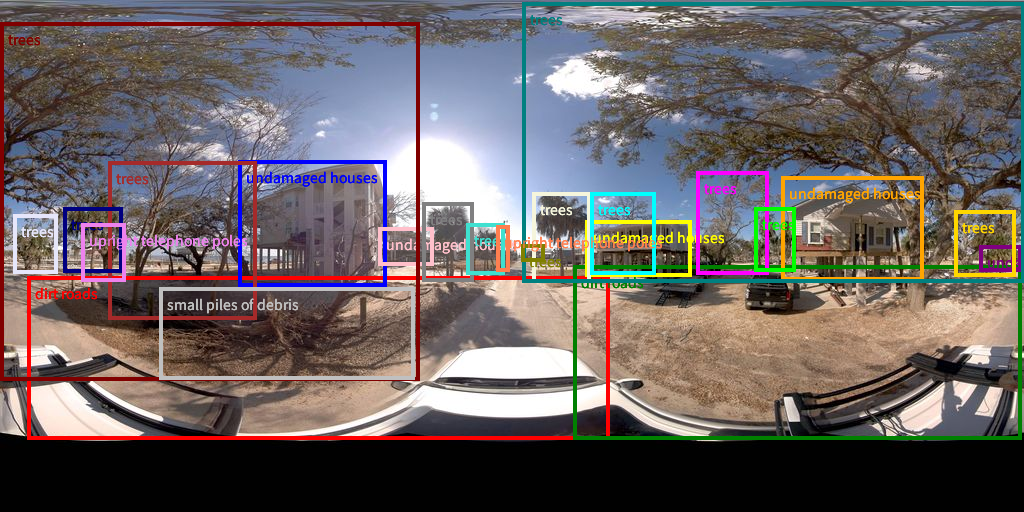

In [10]:
plot_bounding_boxes(im, response.text)
im

In [95]:
from PIL import Image
from io import BytesIO
from pathlib import Path

output_dir = Path("assets/2d_spatial_understanding")

image = output_dir.joinpath("20250413144139486858_0_challenge_view.png")


prompt_l1 = """
Detect the 2d bounding bx of the pipeline.
"""

# Load and resize image
im_raw = Image.open(BytesIO(open(image, "rb").read()))
im_raw.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model="gemini-2.5-pro-preview-03-25",
    contents=[prompt_l1, im_raw],
    config=types.GenerateContentConfig(
        temperature=0,
        response_mime_type="application/json",
    )
)

JSON(json.loads(response.text))

<IPython.core.display.JSON object>

(500, 430)


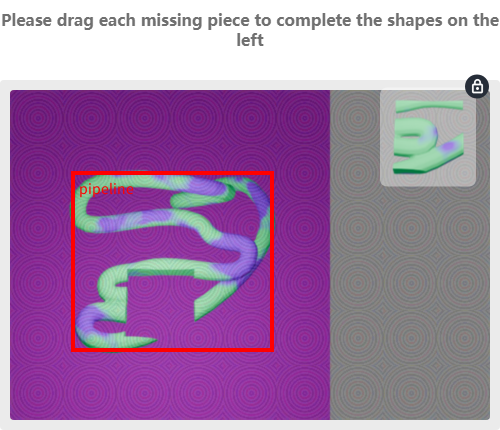

In [96]:
plot_bounding_boxes(im_raw, response.text)
im_raw

In [99]:
prompt_l2 = """
detect the 2d bounding box of the place that's been cut off as `missing piece`.

- The missing piece MUST **within** the red rectangular box in the diagram.
- There are only-one missing piece in the diagram.
"""

im_l2 = im_raw.copy()

# Run model to find bounding boxes
response_l2 = client.models.generate_content(
    model="gemini-2.5-pro-preview-03-25",
    contents=[prompt_l1, im_l2, response.text, prompt_l2],
    config=types.GenerateContentConfig(
        temperature=0,
        response_mime_type="application/json",
    )
)
JSON(json.loads(response_l2.text))

<IPython.core.display.JSON object>

(500, 430)


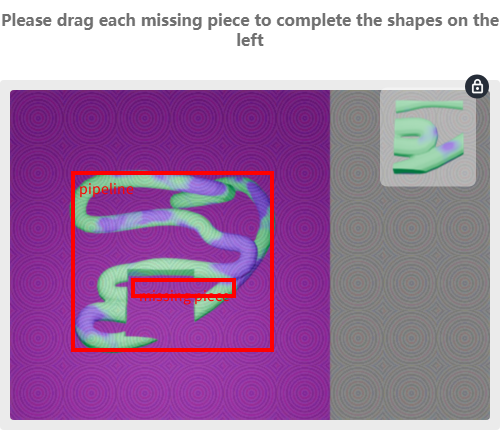

In [100]:
plot_bounding_boxes(im_l2, response_l2.text)
im_l2